In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculation Procedure
## A: Calculate emission intensities from coal plants + determine regional emission intensities
The EIA gives information on the heat content of coal burnt at power stations across the country and the mine this coal came from through the EIA's fuel receipts data from Form EIA-923 (Schedule 2) (https://www.eia.gov/electricity/data/eia923/).

Calculate the emissions intensity of coal from each source mine, based on the coal's heat content (Btu/short ton), type, and the following information on emissions intensity per Btu for given coal types (given by the EIA here: https://www.eia.gov/tools/faqs/faq.php?id=73&t=11)
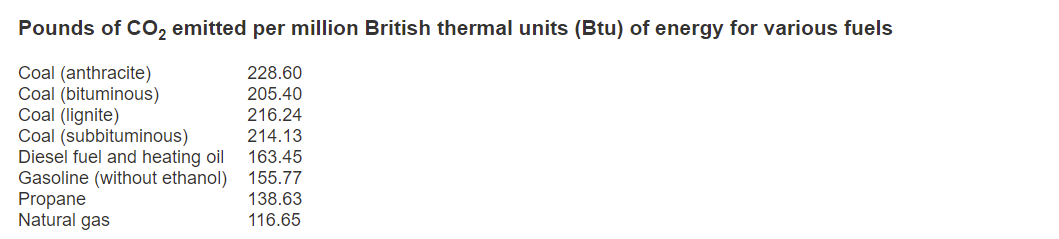

## B: Calculate regional emission intensities from coal plant intensities
Roughly 2/3 of producing coal mines are not covered by the datasource above (presumably because they do not sell coal to U.S. power plants). Therefore regional emission intensities can be used to approximate the emissions intensities of coal from these mines based on their coal production region. The regional intensities can be calculated from the emission intensities above.

## C. Calculate emissions intensity per employee of all producing coal mines
The EIA has annual production data on all coal mines in the U.S., as well as the number of employees and the coal production region of each mine (https://www.eia.gov/coal/data.php#production).

1. Allocate each mine an emissions intensity (per short ton coal produced) based on those derived in either (A) or (B).
2. Calculate the total annual emissions of each mine.
3. Use total emissions and number of employees to derive emissions intensity per employee.

# A: Calculate emission intensities from coal plants + determine regional emission intensities

In [2]:
# Load in fuel receipts data
receipts = pd.read_excel(
    '../Input/f923_2020/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx',
    sheet_name='Page 5 Fuel Receipts and Costs',
    header=4,
    dtype={'Average Heat\nContent': np.float64, 'QUANTITY': np.float64}
)
receipts_coal = receipts[receipts['FUEL_GROUP'] == 'Coal'].rename(
    columns={'Coalmine\nMsha Id': 'MSHA ID',
             'Average Heat\nContent': 'Avg Heat Content (MMBtu/short ton)',
             'QUANTITY': 'Quantity burnt (short tons)'}
)

# Extract information needed for weighted average, drop NA MSHA codes, and convert MSHA ID to int
sales_emissions = receipts_coal[['MSHA ID', 'Avg Heat Content (MMBtu/short ton)', 'ENERGY_SOURCE',
                                 'Quantity burnt (short tons)']]
sales_emissions = sales_emissions.dropna(subset=['MSHA ID'])
sales_emissions['MSHA ID'] = sales_emissions['MSHA ID'].astype(int)

# Create dictionary containing emissions factors for different coal types (lb CO2 / MMBtu)
ef = {'ANT': 228.60, 'BIT': 205.40, 'LIG': 216.24, 'SUB': 214.13}
ef_avg = sum(ef.values()) / len(ef)

# Add emissions factor column to df based on coal type
sales_emissions['lb CO2/MMBtu'] = sales_emissions['ENERGY_SOURCE'].apply(
    lambda x: ef[x] if x != 'WC' else ef_avg)

# Compute total emissions for each sale (lb CO2e p.a.)
sales_emissions['lb CO2 emitted'] = sales_emissions['Avg Heat Content (MMBtu/short ton)'] * \
    sales_emissions['Quantity burnt (short tons)'] * \
    sales_emissions['lb CO2/MMBtu']

# Group emissions and quantity by coal mine via MSHA ID, and compute average emissions intensity for each coal mine
mine_emission_intensity = sales_emissions[[
    'MSHA ID', 'lb CO2 emitted', 'Quantity burnt (short tons)']
].groupby(by='MSHA ID', as_index=False).sum()
mine_emission_intensity['lb CO2e/short ton'] = mine_emission_intensity['lb CO2 emitted'] / \
    mine_emission_intensity['Quantity burnt (short tons)']

Page 1 Generation and Fuel Data
Page 5 Fuel Receipts and Costs
Page 6 Plant Frame
Page 1 Energy Storage
Page 1 Puerto Rico
Page 2 Oil Stocks Data
Page 2 Stocks Data
Page 3 Boiler Fuel Data
Page 4 Generator Data
Page 6 Plant Frame Puerto Rico


# B: Calculate regional emission intensities from coal plant intensities
EIA fuel receipts does not contain information on coal supply region, however EIA production data (used below) does.
Therefore, aggregate after merging emissions intensities onto production data.

In [3]:
# Read in data, add FIPS codes
data = pd.read_excel('../Input/coalpublic2020.xls', header=3, usecols='B:G,J,M:P')
fips = pd.read_csv('../Temp/fips.csv',
                   header=None,
                   usecols=[0, 1, 2],
                   names=['FIPS', 'Mine County', 'Mine State'],
                   encoding='unicode_escape',
                   dtype={'FIPS': str}
                   )
data = pd.merge(data, fips.iloc[:, 0:3], on=['Mine County', 'Mine State'])

# Merge emissions intensity onto production data via MSHA ID
# (NaN values are for mines not accounted for in receipts data)
data_merged = pd.merge(
    data,
    mine_emission_intensity[['MSHA ID', 'lb CO2e/short ton', 'lb CO2 emitted',
                             'Quantity burnt (short tons)']],
    how='left',
    on='MSHA ID'
)

# Pull regional intensities from data_merged
regional_intensities_revised = data_merged.iloc[:, [7, 13, 14]].dropna(
).groupby(by='Coal Supply Region').sum()
regional_intensities_revised['lb CO2e/short ton'] = regional_intensities_revised['lb CO2 emitted'] / \
    regional_intensities_revised['Quantity burnt (short tons)']
data_merged = data_merged.drop(
    columns=['Quantity burnt (short tons)', 'lb CO2 emitted']
)

# C. Calculate emissions intensity per employee of all producing coal mines

In [4]:
MSHA_emissions = data_merged.copy()

# Replace missing emissions intensities with the correponding regional intensity
MSHA_emissions = MSHA_emissions.fillna(value="")

for i in np.arange(len(MSHA_emissions)):
    if MSHA_emissions.iloc[i, 12] == "":
        MSHA_emissions.iloc[i, 12] = regional_intensities_revised.loc[
            MSHA_emissions.iloc[i, 7], 'lb CO2e/short ton']

# Compute total emissions per mine
MSHA_emissions['short ton CO2'] = MSHA_emissions['Production (short tons)'] * \
    MSHA_emissions['lb CO2e/short ton'] / 2000
MSHA_emissions['short ton CO2'] = MSHA_emissions['short ton CO2'].astype(float)

# Compute emissions per employee (units: million lb CO2e/employee p.a.)
MSHA_emissions['short ton CO2/employee'] = MSHA_emissions['short ton CO2'] / \
    MSHA_emissions['Average Employees']

# Separate data from actively producing mines from those for which production = 0
MSHA_emissions_producing = MSHA_emissions[
    MSHA_emissions['Production (short tons)'] != 0].reset_index()

# Group emissions and employees by FIPS
county_emissions = MSHA_emissions_producing[
    ['Mine State', 'Mine County', 'short ton CO2', 'Production (short tons)',
     'Average Employees', 'Labor Hours', 'FIPS']
].groupby(by=['FIPS', 'Mine State', 'Mine County'], as_index=False).sum()

# Compute emissions per employee (units: million lb CO2e/employee p.a.)
county_emissions['short ton CO2/employee'] = county_emissions['short ton CO2'] / \
    county_emissions['Average Employees']


In [5]:
# Export county_emissions as csv
county_emissions.to_csv('../Output/county_emissions_coal.csv', index = False)